In [1]:
import numpy as np
from utils.data_utils import load_simulation_data
from sklearn.linear_model import LogisticRegression as LR
from numpy.linalg import norm

In [2]:
def grad_logis(X,y,model):
    """find gradients of cost function w.r.t. the coefficients in logistic regression"""
    prob = model.predict_proba(X)
    prob1 = prob[:,1]
    X1 = np.hstack([np.ones((X.shape[0],1)), X])
    grad = np.matmul(np.diag(prob1-y),X1)
    return grad

def grad_logis_prob(X,model):
    """find gradients of predicted probability w.r.t. the coefficients in logistic regression"""
    prob = model.predict_proba(X)
    prob01 = prob[:,0]*prob[:,1]
    X1 = np.hstack([np.ones((X.shape[0],1)), X])
    grad = -np.matmul(np.diag(prob01),X1)
    return grad

def grad_logis_ent(X, model):
    """find gradients of entropy w.r.t the coefficients in logistic regression"""
    logprob = model.predict_log_proba(X)
    logprob1m0 = -(logprob[:,1]-logprob[:,0])
    pgrad = grad_logis_prob(X,model)
    grad = np.matmul(np.diag(logprob1m0), pgrad)
    return grad

In [10]:
L0 = 100
B = 30
n_iter = 50
rep = 10
nest = 100

In [11]:
acc_tr = np.zeros((rep,n_iter))
acc_tr0 = np.zeros((rep,n_iter))
acc_tr1 = np.zeros((rep,n_iter))
acc_L = np.zeros((rep,n_iter))
acc_L0 = np.zeros((rep,n_iter))
acc_L1 = np.zeros((rep,n_iter))
acc_U = np.zeros((rep,n_iter))
acc_U0 = np.zeros((rep,n_iter))
acc_U1 = np.zeros((rep,n_iter))
acc_te = np.zeros((rep,n_iter))
acc_te0 = np.zeros((rep,n_iter))
acc_te1 = np.zeros((rep,n_iter))

In [12]:
for state in range(rep):
    print(state)
    Xtr,Xte,ytr,yte,ztr,zte = load_simulation_data(simulation_params = {'p':100,'q':40, 'r':10, 'b':0, 't':0}, 
                                               n1=2000, n2=1000, svm=False, random_state=state, intercept=False, 
                                               train_frac = 0.7)
    # data preprocessing
    yytr = ytr.ravel()
    yyte = yte.ravel()
    zztr = ztr.ravel()
    zzte = zte.ravel()
    Xtr0 = Xtr[zztr==0]
    Xtr1 = Xtr[zztr==1]
    Xte0 = Xte[zzte==0]
    Xte1 = Xte[zzte==1]
    yytr0 = yytr[zztr==0]
    yytr1 = yytr[zztr==1]
    yyte0 = yyte[zzte==0]
    yyte1 = yyte[zzte==1]
    
    # initialization
    N = zztr.shape[0]
    perm = np.random.permutation(N)
    XL = Xtr[perm[0:L0],:]
    XU = Xtr[perm[L0:],:]
    yL = yytr[perm[0:L0]]
    yU = yytr[perm[L0:]]
    zL = zztr[perm[0:L0]]
    zU = zztr[perm[L0:]]
    XL0 = XL[zL==0]
    XL1 = XL[zL==1]
    yL0 = yL[zL==0]
    yL1 = yL[zL==1]
    XU0 = XU[zU==0]
    XU1 = XU[zU==1]
    yU0 = yU[zU==0]
    yU1 = yU[zU==1]
    
    for i in range(n_iter):
        # model fitting and prediction
        clf=LR(random_state=state).fit(XL, yL)
        acc_tr[state, i] = clf.score(Xtr, yytr)
        acc_tr0[state, i] = clf.score(Xtr0, yytr0)
        acc_tr1[state, i] = clf.score(Xtr1, yytr1)
        acc_L[state, i] = clf.score(XL, yL)
        acc_L0[state, i] = clf.score(XL0, yL0)
        acc_L1[state, i] = clf.score(XL1, yL1)
        acc_U[state, i] = clf.score(XU, yU)
        acc_U0[state, i] = clf.score(XU0, yU0)
        acc_U1[state, i] = clf.score(XU1, yU1)
        acc_te[state, i] = clf.score(Xte, yyte)
        acc_te0[state, i] = clf.score(Xte0, yyte0)
        acc_te1[state, i] = clf.score(Xte1, yyte1)
        
        # modify next labeled and ulabeled sets
        
        # worst group selection
        if acc_L0[state, i]<acc_L1[state, i]:
            wg = 0
            Xw = XL0
            yw = yL0
        else:
            wg = 1
            Xw = XL1
            yw = yL1
        
        # calculate entropy first, and then select the "nest" number of input data points
        
        prob = clf.predict_proba(XU)
        ent = -prob[:,0]*np.log(prob[:,0])-prob[:,1]*np.log(prob[:,1])
        arg_ent = np.argpartition(ent, -nest)
        lind_ent = arg_ent[-nest:]
        uind_ent = arg_ent[:-nest]
        Xent = XU[lind_ent,:]
        # print(Xent.shape)
        
        grad_w = np.mean(grad_logis(Xw, yw, clf), axis=0)
        # print(grad_w.shape)
        grad1 = grad_logis_prob(Xent,clf)
        grad0 = -grad1
        # prob = clf.predict_proba(XU)[:,1]
        prob_grad = clf.predict_proba(Xent)
        prob2 = 2*prob_grad[:,1]-1
        grad_ent = np.multiply(grad1, prob2[:,None]) # expected grad
        # print(grad_U.shape)
        cossim = np.matmul(grad_ent, grad_w)
        # cossim = np.abs(cossim)
        # print(cossim.shape)
        arg_grad = np.argpartition(cossim,-B)
        lind_grad = arg_grad[-B:]
        uind_grad = arg_grad[:-B]
        
        lind = lind_ent[lind_grad]
        uind = np.append(uind_ent, lind_ent[uind_grad])
        
        # selection
        XL = np.vstack([XL, XU[lind,:]])
        yL = np.append(yL, yU[lind])
        zL = np.append(zL, yU[lind])
        XU = XU[uind,:]
        yU = yU[uind]
        zU = zU[uind]
        XL0 = XL[zL==0]
        XL1 = XL[zL==1]
        yL0 = yL[zL==0]
        yL1 = yL[zL==1]
        XU0 = XU[zU==0]
        XU1 = XU[zU==1]
        yU0 = yU[zU==0]
        yU1 = yU[zU==1]
        

0
1
2
3
4
5
6
7
8


/home/srp/.pyenv/versions/miniconda3-4.7.12/envs/pytorch15/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


9


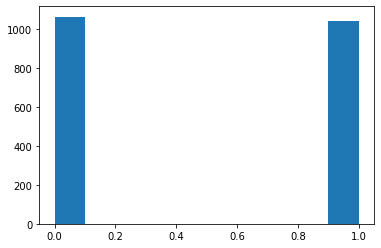

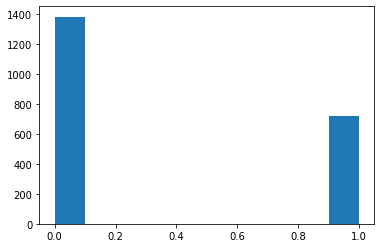

In [43]:
plt.hist(ytr)
plt.show()
plt.hist(ztr)
plt.show()

In [13]:
print(np.mean(acc_te, axis=0))
print(np.mean(acc_te0, axis=0))
print(np.mean(acc_te1, axis=0))


[0.68655556 0.71711111 0.74211111 0.763      0.78588889 0.79744444
 0.80766667 0.815      0.82411111 0.82988889 0.83366667 0.84266667
 0.84655556 0.85144444 0.853      0.85688889 0.85811111 0.86144444
 0.86277778 0.86633333 0.86733333 0.86655556 0.86955556 0.87122222
 0.87255556 0.87077778 0.874      0.87544444 0.87322222 0.87544444
 0.87333333 0.873      0.87233333 0.87311111 0.87433333 0.87233333
 0.87211111 0.87211111 0.87244444 0.87233333 0.87355556 0.87266667
 0.87155556 0.87222222 0.87266667 0.87311111 0.87277778 0.87155556
 0.87188889 0.87244444]
[0.69014149 0.72339553 0.7531818  0.77491756 0.8004232  0.81606647
 0.82947956 0.83752715 0.84729046 0.85431757 0.85857809 0.86785044
 0.87527913 0.87915186 0.88108398 0.8881845  0.89222779 0.89517514
 0.89843794 0.90141874 0.90417024 0.90472289 0.90569971 0.90711574
 0.90893574 0.9066788  0.90977666 0.90917895 0.90685674 0.90839196
 0.90670556 0.90565532 0.9050907  0.90505332 0.90785775 0.90571271
 0.90436635 0.90417647 0.9038424  0.90

In [7]:
ind1 = np.array([1,3,5,7,9])
ind2 = np.array([2,3])
ind3 = np.array([0,1,4])

ind4 = ind1[ind2[0]]
ind5 = np.append(ind1[ind2[1]],ind1[ind3])

print(ind4)
print(ind5)

5
[7 1 3 9]


In [8]:
results = {'acc_te':acc_te, 'acc_te0':acc_te0, 'acc_te1':acc_te1}

In [9]:
import pickle
with open('fairAL_nested.res','wb') as f:
    pickle.dump(results, f)

In [31]:
grads_m0_ = grad_logis_prob(XL0,clf)
grads_m1_ = grad_logis_prob(XL1,clf)
grads_m_= grad_logis_prob(XL,clf)
grads_ind = grad_logis_prob(XU,clf)
grads_ind0 = grad_logis_prob(XU0,clf)
grads_ind1 = grad_logis_prob(XU1,clf)

In [27]:
grads_m = np.mean(grads_m_,axis=0)
grads_m0 = np.mean(grads_m0_,axis=0)
grads_m1 = np.mean(grads_m1_,axis=0)

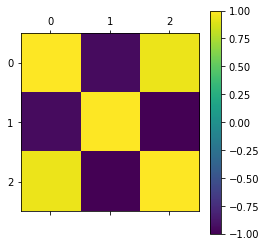

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

all_grads = np.row_stack((grads_m, grads_m0-grads_m, grads_m1-grads_m))
sim_mat = cosine_similarity(all_grads, all_grads)

plt.matshow(sim_mat)
plt.colorbar()

In [48]:
sim_mat

array([[ 1.        , -0.93933393,  0.93933393],
       [-0.93933393,  1.        , -1.        ],
       [ 0.93933393, -1.        ,  1.        ]])

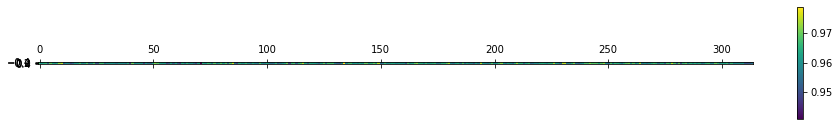

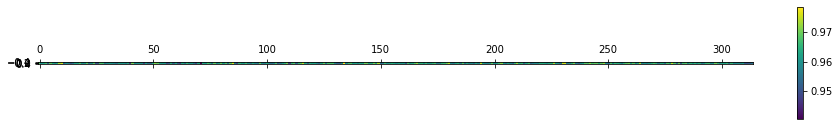

In [41]:
sim_mat_ind00 = cosine_similarity(np.expand_dims(grads_m0,axis=0), grads_ind0)
plt.matshow(sim_mat_ind00)
plt.colorbar()
sim_mat_ind01 = cosine_similarity(np.expand_dims(grads_m1,axis=0), grads_ind0)
plt.matshow(sim_mat_ind01)
plt.colorbar()

In [ ]:
sim_mat_ind0 = cosine_similarity(all_grads, grads_ind1)
plt.matshow(sim_mat_ind1)
plt.colorbar()